## Tree-based methods 
In this lab, we will go over how to implement tree-based classification and regression methods. 

## Goals of the lab:
* Learn to use the `tree` library to build 
classification trees & regression trees
* Learn how to use the `randomForest` package to apply bagging and random forests to a sample dataset
* Learn to use the `gbm` package to boost trees

This lab draws from the practice sets at the end of Chapter 8 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

##  Pros and cons of trees {the statistical ones}
  * Trees are interpretable. They are amenable to visualization and their visualization can be easily interpreted (if they are small)
  * Trees can handle qualitative predictors without having to create dummy variables
  <br>
  <br>

  * However, trees do not generally have the same predictive accuracy as other regression and classification approaches
  * Trees can be sensitive to small changes in the data (i.e., flexible), so that even small differences in the data used to construct trees can result in drastically different decision trees
 
## Some solutions 

To minimize these shortcomings, you can aggregate many decision trees using *bagging*, *random forests*, and *boosting*. 

---
# Fitting classification trees

In [1]:
library(ISLR)

# install.packages('tree') #uncomment to install 
library(tree) #this is the library needed for tree regression and classification

Warning message:
“package ‘tree’ was built under R version 3.4.4”

To start, we are going to construct a classification tree using the `Carseats` dataset. Here, `Sales` is a continuous variable, so we will binarize it for compatiblity with classification trees.

In [2]:
# ?Carseats
# head(Carseats) #if you need a reminder of the structure of the dataset

In [3]:
#if sales are <= $8000, then sales are not high 
# otherwise, they are. 
High <- as.factor(ifelse(Carseats$Sales<=8, "No", "Yes") )

Carseats['High'] <- High #add the binarized variable to the dataframe

Now we'll use the `tree` function to fit a classification tree. This will predict `High` using all variables except `Sales` (which we transformed above into `High`). 

In [4]:
tree.carseats <- tree(High~.-Sales, Carseats)

The summary of the tree will list the variables used as nodes in the tree, the number of terminal nodes, and the training error rate. 

In [6]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

You can see that the training error rate was 9%. The residual mean deviance is also reported. A small deviance indicates a tree that fits the training data well. The residual mean deviance is the deviance divided by the number of observations ($n$) subtracted from the number of terminal nodes in the tree ($|T_0|$).  

In this case, the deviance is $170.7$. There are 400 observations for Sales, and 27 terminal nodes, so $(n-|T_0|)$ is $373$. 

Now let's plot the tree we've constructed.

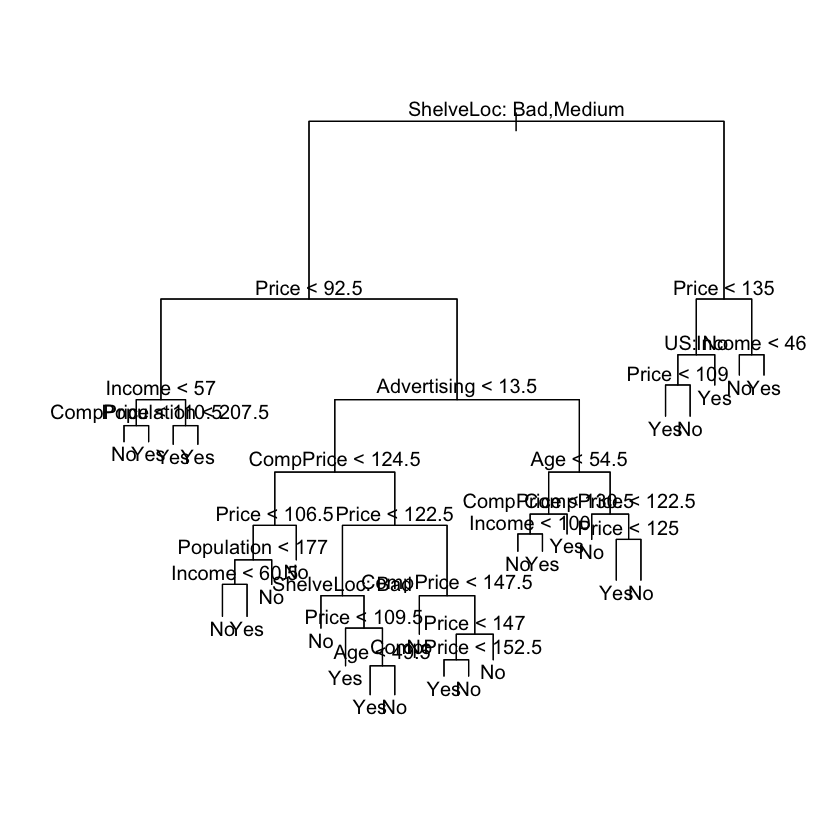

In [11]:
plot(tree.carseats) #this will create the basic tree structure
text(tree.carseats, pretty=0) #this will annotate the tree with predictors and outcomes
#pretty=0 means that the tree will display the full names of the qualitative predictors instead of 
#single-letter abbreviations 

The most important indicator of sales seems to be the shelving location, because the first branch splits subsequent branches according to whether shelving location is bad or medium.

You can also just type the tree object name to see output for each branch of the tree. Below, the split criterion is displayed ($Price<92.5$), the number of observations for each branch is shown, the deviance, the overall prediction for that branch, and the number of observations in that branch that take on the values $Yes$ or $No$.

In [12]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

Now let's estimate the test error of this classification tree. 

In [22]:
set.seed (2)
train=sample(1:nrow(Carseats), 200) #50/50 split
Carseats.test=Carseats[-train ,] #indices for test set
High.test=High[-train ] #get test data
tree.carseats=tree(High~.-Sales, Carseats, subset=train ) #train the tree
tree.pred=predict(tree.carseats, Carseats.test, type="class") #make a prediction using the test set
#class instructs R to return the class prediction
table(tree.pred, High.test) #compare predictions with test data

         High.test
tree.pred No Yes
      No  86  27
      Yes 30  57

In [25]:
total_accuracy = (86 + 57) / 200 #look at total accuracy
total_accuracy

[1] 0.715

Now let's prune the tree to determine the optimal level of complexity. The function 
`cv.tree` will perform cross-validation to determine the complexity that maximizes the bias-variance tradeoff. 

In [26]:
set.seed(3)
cv.carseats = cv.tree(tree.carseats, FUN=prune.misclass) 
#FUN=prune.misclass indicates that we want classification error rate to guide the 
#cross-validated pruning process 
names(cv.carseats) #this function reports the terminal number of nodes 
#for each tree considered (size), the corresponding error rate (dev),
#and the value of the cost complexity parameter (k, corresponding to alpha)

[1] "size"   "dev"    "k"      "method"

In [27]:
cv.carseats

$size
[1] 19 17 14 13  9  7  3  2  1

$dev
[1] 55 55 53 52 50 56 69 65 80

$k
[1]       -Inf  0.0000000  0.6666667  1.0000000  1.7500000  2.0000000  4.2500000
[8]  5.0000000 23.0000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

It appears that the tree with 9 terminal nodes results in the lowest cross-validated error rate, with 50 cross-validation errors. Below is the CV error rate as function of tree size.

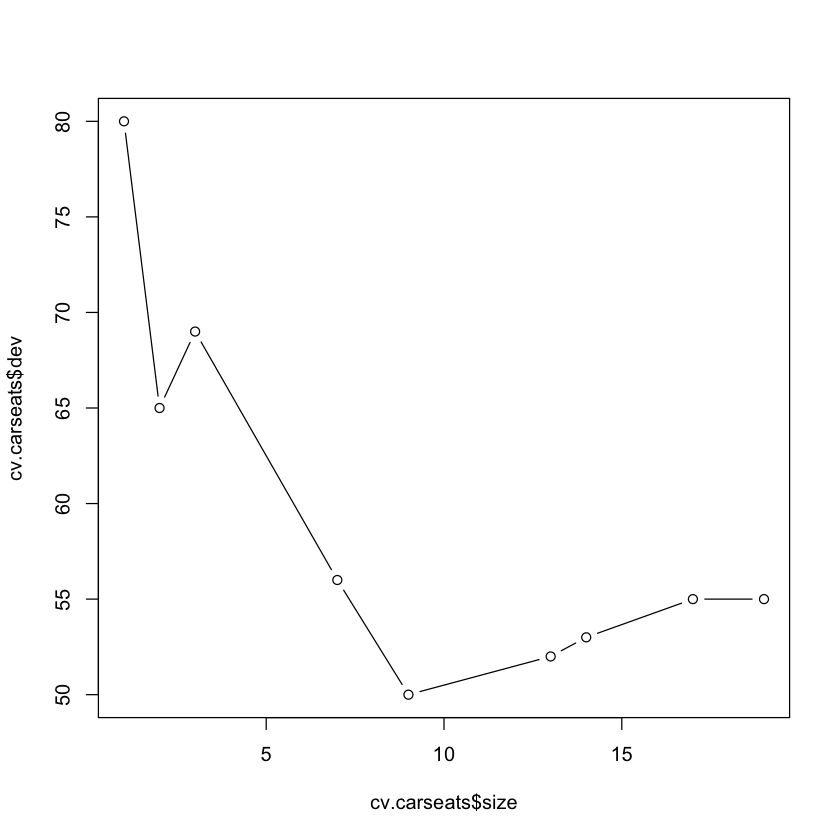

In [31]:
plot(cv.carseats$size ,cv.carseats$dev ,type="b")

Now we can apply the `prune.misclass()` function to prune the tree to have the number of nodes to match the best CV error above. 

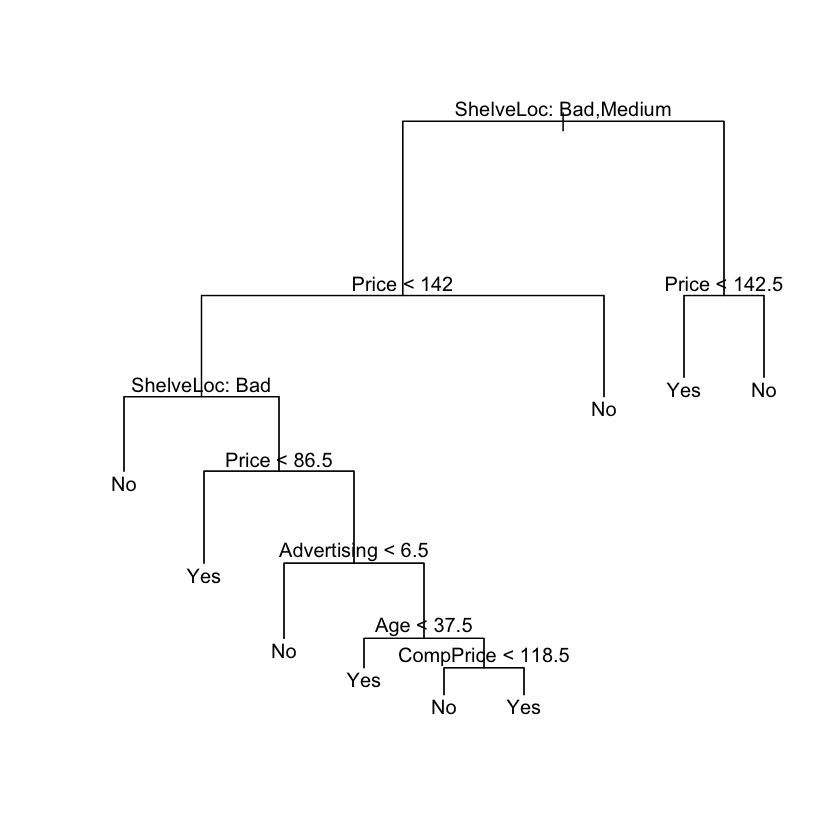

In [33]:
prune.carseats=prune.misclass(tree.carseats,best=9) #getting the pruned tree
plot(prune.carseats) #plotting the newly pruned tree
text(prune.carseats, pretty=0)

Let's see how well this pruned tree classifies test set observations using the `predict` function.

In [37]:
tree.pred=predict(prune.carseats, Carseats.test, type="class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  94  24
      Yes 22  60

In [39]:
total_pruned_accuracy = (94+60)/200
total_pruned_accuracy

[1] 0.77

The predictive classification accuracy has improved and the tree is now more interpretable.

---
# Fitting regression trees 

Now let's fit a regression tree to the `Boston` dataset.

In [47]:
library(MASS)
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [46]:
set.seed(1)
train = sample(1: nrow(Boston), nrow(Boston)/2) #create the training set
tree.boston=tree(medv~.,Boston, subset=train) #fit the regression tree
summary(tree.boston) #summarize


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "lstat" "rm"    "dis"  
Number of terminal nodes:  8 
Residual mean deviance:  12.65 = 3099 / 245 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-14.10000  -2.04200  -0.05357   0.00000   1.96000  12.60000 

Notice that the output of summary() indicates that only three of the variables
have been used in constructing the tree. 

For a regression tree, the deviance is just the sum of the squared errors for the tree.

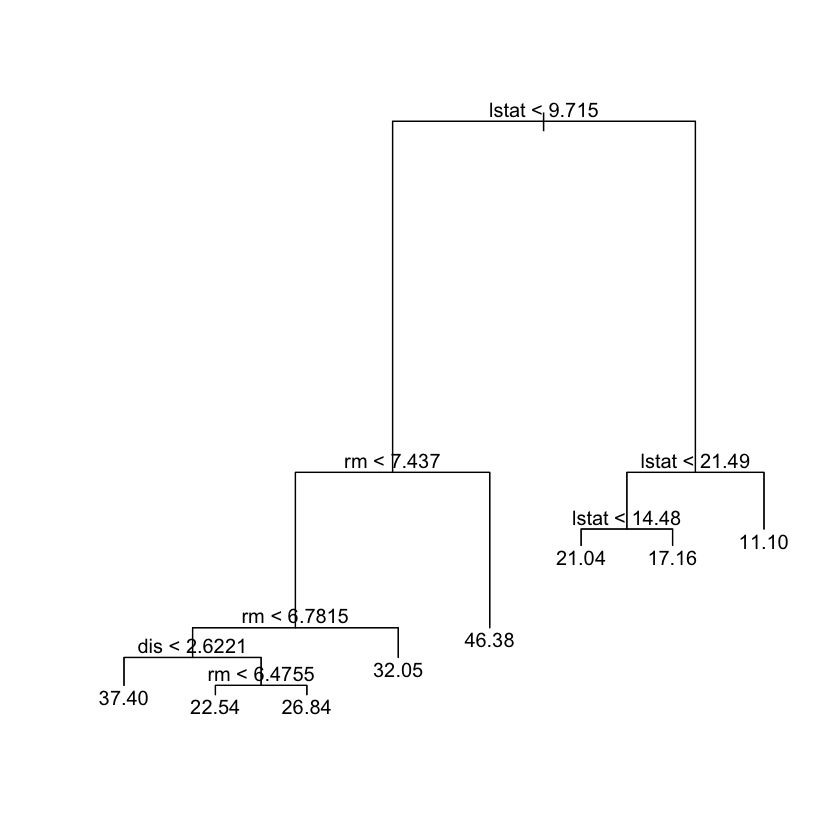

In [49]:
plot(tree.boston)
text(tree.boston, pretty=0)

The variable lstat measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of lstat correspond
to more expensive houses. The tree predicts a median house price
of $46,400 for larger homes in suburbs in which residents have high socioeconomic
status (rm>=7.437 and lstat<9.715).

Now let's prune the tree.

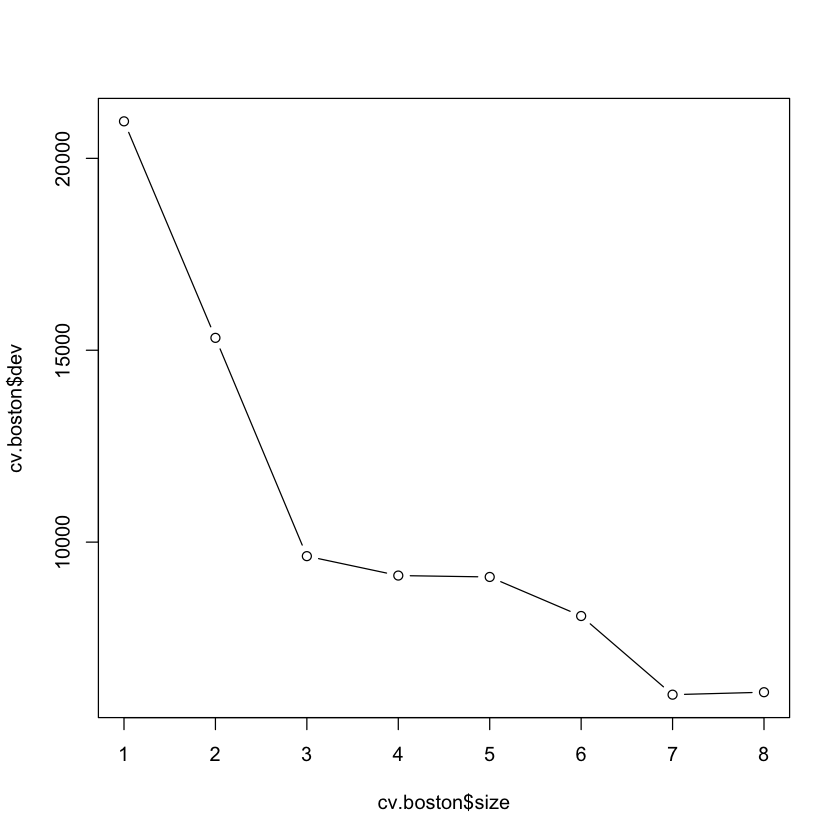

In [52]:
#first, let's look at the CV error as a function tree size
cv.boston=cv.tree(tree.boston) 
plot(cv.boston$size, cv.boston$dev,type='b')

Using these CV results, we will use the unpruned tree to make predictions on a test set.

[1] 25.04559

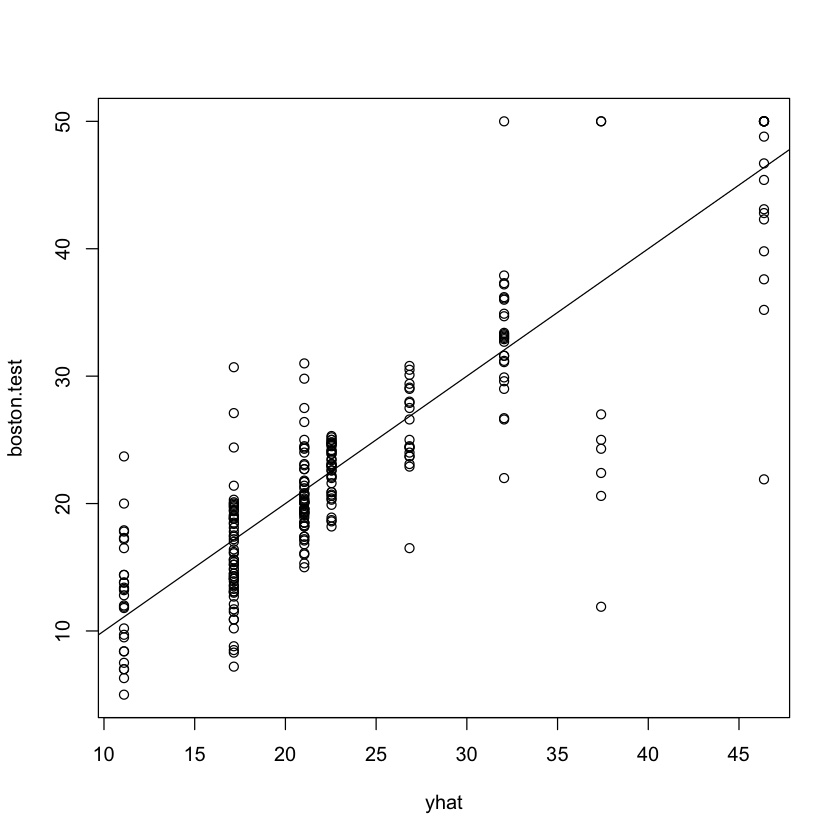

In [65]:
yhat=predict(tree.boston,newdata=Boston[-train ,])
boston.test=Boston[-train, "medv"]
plot(yhat ,boston.test)
abline(0,1)
mean((yhat-boston.test)^2)

The test set MSE associated with the regression tree is
25.05. The square root of the MSE is therefore around 5.005, indicating
that this model leads to test predictions that are within around $5, 005 of
the true median home value for the suburb.

*Note*: In this case, the most complex tree was selected by cross-validation. However, you can manually prune the tree using the following and subsequently use a pruned tree for test set predictions.

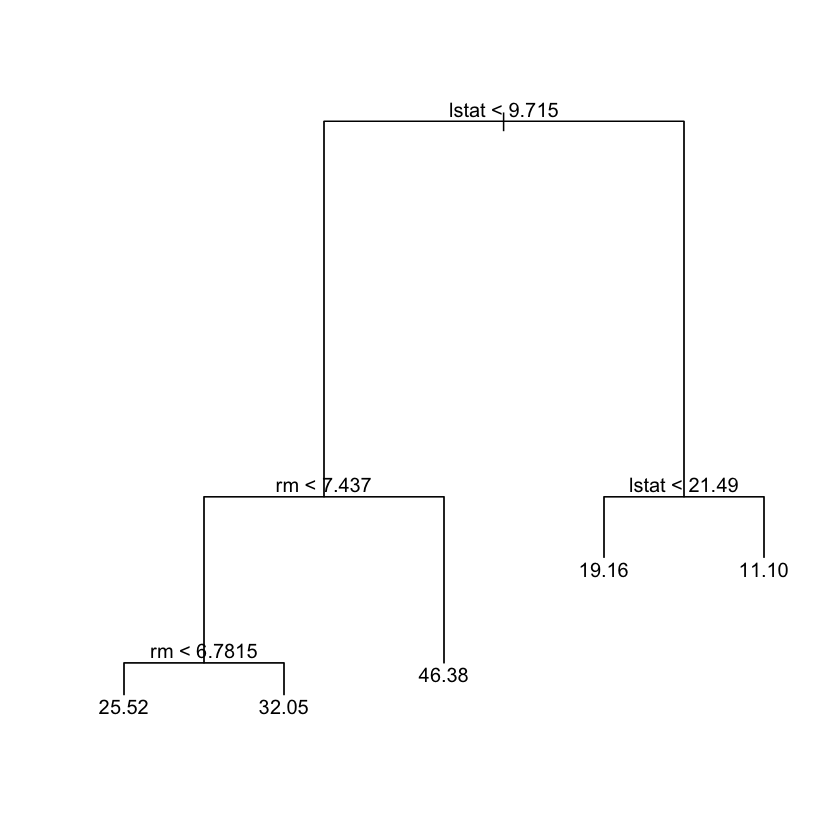

In [53]:
prune.boston=prune.tree(tree.boston,best=5) #manually selecting a 5-node tree
plot(prune.boston)
text(prune.boston,pretty=0)

# Bagging and random forests

Now we will apply bagging and random forests to the `Boston` dataset using the `randomForest` package.

Bagging is just a special case of a random forest with $m=p$, so the randomForest() function can be used for both purposes. 

In [68]:
# install.packages('randomForest')

In [70]:
library(randomForest)
set.seed(1)

#the arg. mtry=13 indicates that all 13 predictors should be considered
#for each split of the tree (i.e., bagging should be done, m=p)
bag.boston=randomForest(medv~.,data=Boston, subset=train, mtry=13,
                       importance=TRUE)
bag.boston


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.15723
                    % Var explained: 86.49

[1] 13.50808

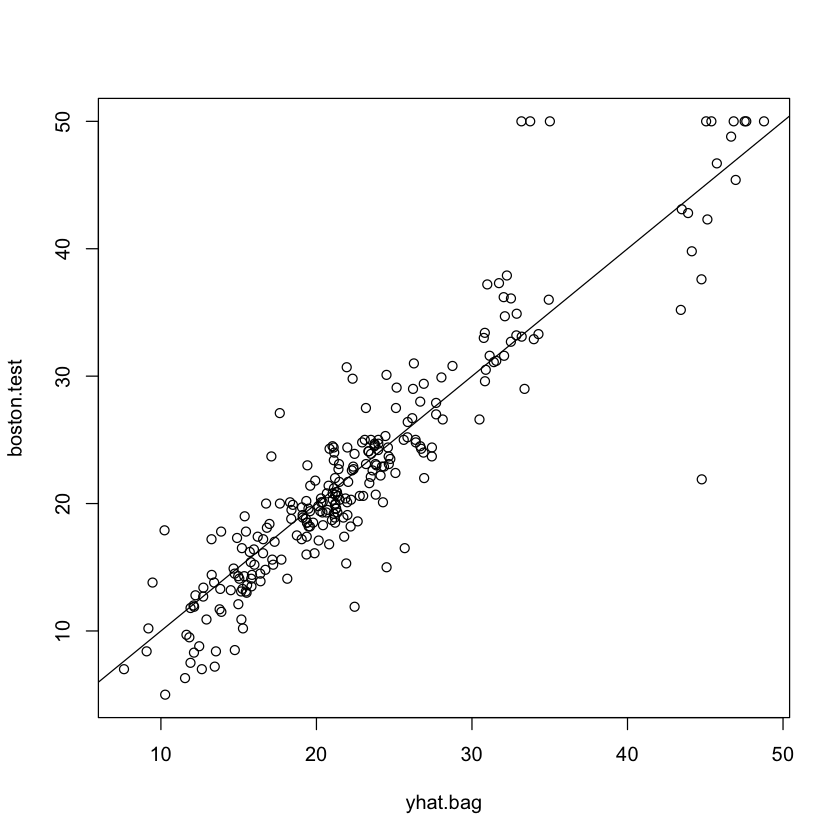

In [71]:
#test set performance of this bagged regression
yhat.bag = predict (bag.boston, newdata=Boston[-train ,])
plot(yhat.bag, boston.test)
abline(0,1)
mean((yhat.bag - boston.test)^2)

The test set MSE associated with the bagged regression tree is ~13, almost
half that obtained using an optimally-pruned single tree. We could change
the number of trees grown by randomForest() using the ntree argument:

In [72]:
bag.boston=randomForest(medv~.,data=Boston, subset=train, mtry=13,
                       importance=TRUE, ntree=25) #grow 25 trees
yhat.bag = predict (bag.boston,newdata=Boston[-train ,])
mean((yhat.bag-boston.test)^2)

[1] 13.66237

Growing a random forest instead is implemented similarly. We just use a smaller value for the `mtry` argument. Note that, by default, randomForest() will use $p$/3 variables for building a random forest of regression trees, and $\sqrt p$ variables for building a random forest of classification trees.

In [77]:
set.seed(1)
rf.boston=randomForest(medv~.,data=Boston, subset=train ,
mtry=6, importance=TRUE)
yhat.rf = predict(rf.boston, newdata=Boston[-train ,])
mean((yhat.rf-boston.test)^2)

[1] 11.66454

The test set MSE is ~11. Random forests yielded an
improvement over bagging in this case.

The importance() function shows the importance of each variable. 

In [78]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,12.132320,986.50338
zn,1.955579,57.96945
indus,9.069302,882.78261
chas,2.210835,45.22941
nox,11.104823,1044.33776
rm,31.784033,6359.31971
age,10.962684,516.82969
dis,15.015236,1224.11605
rad,4.118011,95.94586
tax,8.587932,502.96719


This shows two metrics of importance, %IncMSE and IncNodePurity (see ISLR, p. 330 for explanation).

You can visualize the relative importance of each variable using the below function. Here, we see that lstat (wealth of community) and house size (rm) are the two most important predictor variables.

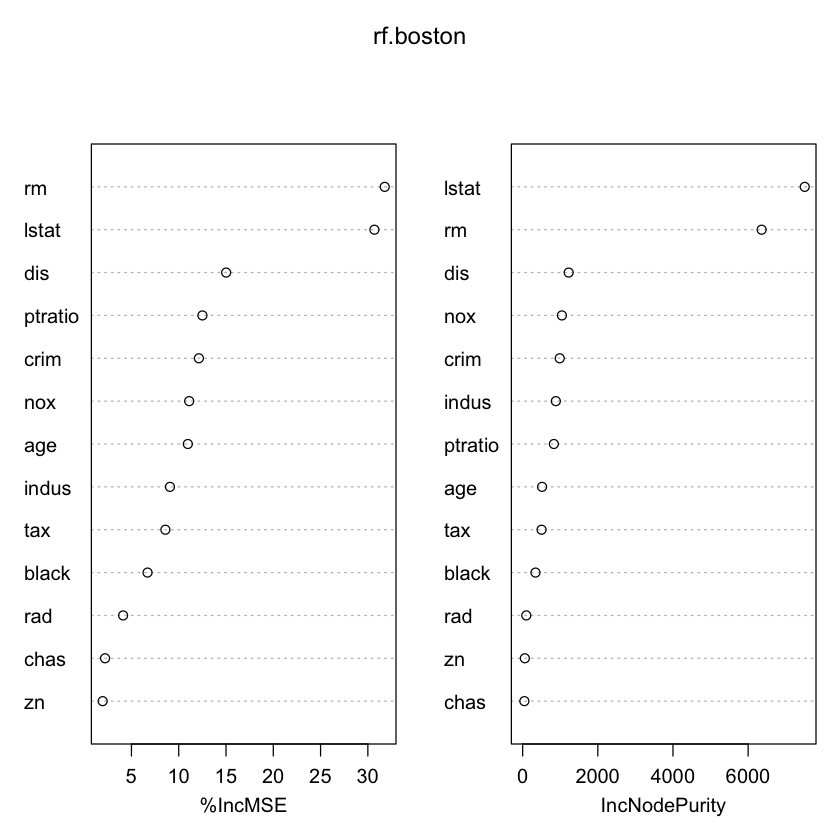

In [79]:
varImpPlot(rf.boston)

# Boosting

Here we'll use the `gbm` package and the `gbm()` function to fit boosted regression trees using hte Boston dataset.

In [82]:
# install.packages('gbm')


The downloaded binary packages are in
	/var/folders/r7/693dgqq51xbfpp9lb55x3_xm0000gn/T//RtmpSnDmM9/downloaded_packages


In [84]:
library(gbm)
set.seed (1)
boost.boston =gbm(medv~.,data=Boston[train ,], distribution=
                  "gaussian", n.trees=5000, interaction.depth=4)

Here, we'll use gbm() with
distribution="gaussian" because this is a regression problem. If it were binary
classification, we would use distribution="bernoulli". The
argument n.trees=5000 means that we want 5000 trees. The option
interaction.depth=4 limits the depth of each tree.

Summary will produce a table of relative influence statistics for each variable, and a relative influence plot.

You can see that lstat and rm are the most important variables.

See p. 331 for an extension of this called partial dependence plots. These plots show the marginal effect of selected variables on the outcome after accounting for the effect of the other variables. 

,var,rel.inf
lstat,lstat,37.0661275
rm,rm,25.3533123
dis,dis,11.7903016
crim,crim,8.0388750
black,black,4.2531659
nox,nox,3.5058570
age,age,3.4868724
ptratio,ptratio,2.2500385
indus,indus,1.7725070
tax,tax,1.1836592


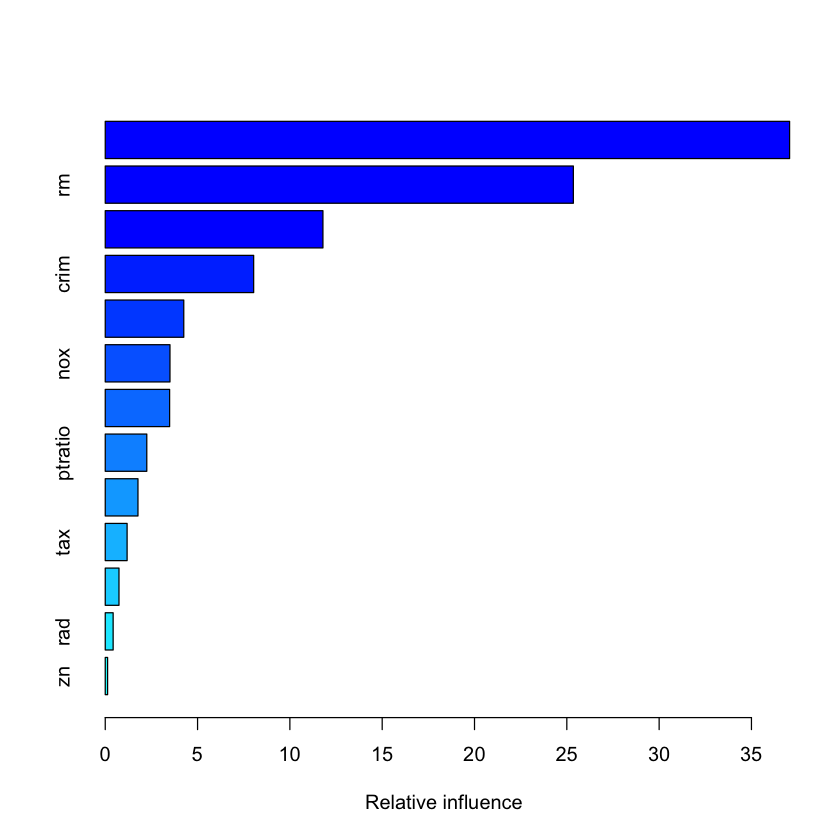

In [85]:
summary(boost.boston)

Now we'll use the boosted model to predict mdev on the test set. 

In [88]:
yhat.boost=predict(boost.boston,newdata=Boston[-train ,],
n.trees=5000)
mean((yhat.boost - boston.test)^2)

[1] 10.81479

The test MSE obtained is 10.8, which is similar to the test MSE for random forests
and better than the MSE we calculated for bagging.

*Note*: You can also construct boosted trees using a different value of the shrinkage parameter, $\lambda$, by specifying the shrinkage argument within the `gbm()` function. For example:

`boost.boston = gbm(medv∼.,data=Boston[train ,], distribution=
"gaussian ",n.trees=5000 , interaction.depth=4, shrinkage=0.2,
verbose=F)`

# Problem set

## Classification trees 

1) This problem involves the OJ data set which is part of the ISLR
package.

(a) Create a training set containing a random sample of 800 observations,
and a test set containing the remaining observations.

(b) Fit a tree to the training data, with Purchase as the response
and the other variables as predictors. Use the summary() function
to produce summary statistics about the tree, and describe the
results obtained. What is the training error rate? How many
terminal nodes does the tree have?

(c) Type in the name of the tree object in order to get a detailed
text output. Pick one of the terminal nodes, and interpret the
information displayed.

(d) Create a plot of the tree, and interpret the results.

(e) Predict the response on the test data, and produce a confusion
matrix comparing the test labels to the predicted test labels.
What is the test error rate?

(f) Apply the cv.tree() function to the training set in order to
determine the optimal tree size.

(g) Produce a plot with tree size on the x-axis and cross-validated
classification error rate on the y-axis.

(h) Which tree size corresponds to the lowest cross-validated classification
error rate?

(i) Produce a pruned tree corresponding to the optimal tree size
obtained using cross-validation. If cross-validation does not lead
to selection of a pruned tree, then create a pruned tree with five
terminal nodes.

(j) Compare the training error rates between the pruned and unpruned
trees. Which is higher?

(k) Compare the test error rates between the pruned and unpruned
trees. Which is higher?

## Regression trees 
2) We applied a classification tree to the Carseats data set after
converting Sales into a qualitative response variable. Now we will
seek to predict Sales using regression trees,
treating the response as a quantitative variable.
<br><br>
(a) Split the data set into a training set and a test set. <br><br>
(b) Fit a regression tree to the training set. Plot the tree, and interpret
the results. What test MSE do you obtain?<br><br>
(c) Use cross-validation in order to determine the optimal level of
tree complexity. Does pruning the tree improve the test MSE?<br><br>
